In [1]:
import numpy as np
# Importing standard Qiskit libraries:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy

In [2]:
def phase_oracle(n, indices_to_mark, name = 'Oracle'):
    '''
    Brief: 
        Generates the orcale matrix to flip the phase of the marked elements. 
        Transforms the matrix to the corresponding unitary gate. In practicality,
        the phase of the winning state(s) get(s) flipped.
    Parameters:
        n = Integer. Number of qubits.
        indices_to_mark = List of intergs representing the indices of winning 
            elements to search for.
        name = Name of the QuantumCircuit object returned.
    Returns: 
        qc = QuantumCircuit object. Has the oracle gate as an element of a circuit.
    '''
    qc = QuantumCircuit(n, name = name) #Initialize a quantum circuit with n qubits.
    oracle_matrix = np.identity(2**n) #Get an identity matrix of n^2 dimension.
    for index_to_mark in indices_to_mark: #For each key in the list of keys...
        oracle_matrix[index_to_mark, index_to_mark] = -1 #flip the sign of the key.
    qc.unitary(oracle_matrix, range(n)) #Apply the matrix to the circuit as a unitary gate
                                        #with range of qubits being [0, ..., n-1].
    return qc

In [3]:
def diffuser(n, name = 'Diffuser'):
    '''
    Brief: 
        Prepares the diffuser circuit and generates the matrix to flip the state 0.
        Physically, the diffuser amplifies the amplitudes of the winning states.
    Parameters: 
        n = Integer. Number of qubits.
    Returns:
        qc = QuantumCircuit object. Diffuser circuit.
    '''
    qc = QuantumCircuit(n, name = name) #Initialize a quantum circuit with n qubits.
    qc.h(range(n)) #Prepare the state |s> = H|0>.
    diffuser_matrix = phase_oracle(n, [0]) #Generate the diffuser matrix.
    qc.append(diffuser_matrix, range(n)) #Apply the diffuser matrix=> V|s>. 
    qc.h(range(n)) #Apply the H gate to the cicuit=> HV|s>.
    return qc 

In [4]:
 def groverSearch(n, marked):
    '''
    Brief: 
        Prpares the entire circuit for the Grover's search algorithm. Searches for 
        the marked elements in the range (0, ..., 2^(n-1)).
    Parameters: 
        n = Integer. Number of qubits.
        marked = List of keys.
    Returns:
        qc = QuantumCircuit object. Final Grover's search circuit.
    '''
    qc = QuantumCircuit(n, n) #Initialize a quantum circuit with n qubits and classical bits.
    M = len(marked) #Say, we have M marked element.
    N = 2 ** n #Total number of elements that can be represented with n qubits.
    theta = np.arcsin(np.sqrt(M/N)) #Get the angle of rotation.
    rounds = int(np.round(np.pi / (2 * theta))- (1 / 2)) #Get the number of rounds needed.
    
    #Print the information:
    print(f"Number of qubits: {n}")
    print(f"Key(s) to search: {marked}")
    print(f"Number of rounds needed: {rounds}") 
    
    qc.h(range(n)) #Step 1: Prepare the superposition states of each qubit.
    
    for _ in range(rounds): #For all the rounds...
        qc.append(phase_oracle(n, marked), range(n)) #Step 2: Apply the phase oracle.
        qc.append(diffuser(n), range(n)) #Step 3: Apply the diffuser.
    qc.measure(range(n), range(n)) #Final step: Measure the qubits.
    return qc

In [5]:
n = int(input("Enter the number of qubits:"))
marked = list(map(int, input('Enter the elements:\n').split()))
qc = groverSearch(n, marked)

Enter the number of qubits:2
Enter the elements:
0 1 2 3
Number of qubits: 2
Key(s) to search: [0, 1, 2, 3]
Number of rounds needed: 0


In [6]:
qc.draw()

┌───┐┌─┐   
q_0: ┤ H ├┤M├───
     ├───┤└╥┘┌─┐
q_1: ┤ H ├─╫─┤M├
     └───┘ ║ └╥┘
c: 2/══════╩══╩═
           0  1

In [7]:
#Run it in the simulator:
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots = 8192).result()
counts = result.get_counts(qc)

{'00': 2110, '01': 2125, '10': 1987, '11': 1970}


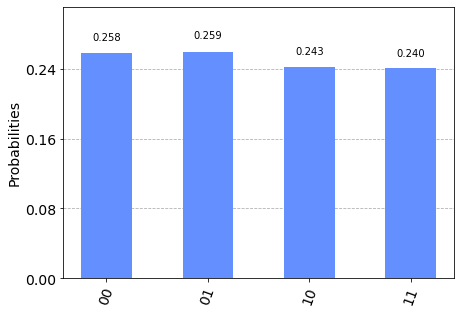

In [8]:
#Print the results:
print(counts)
plot_histogram(counts)